In [2]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping


2024-11-12 16:08:56.638088: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 16:08:56.922434: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 16:08:57.253856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 16:08:57.441288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 16:08:57.535257: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 16:08:58.054827: I tensorflow/core/platform/cpu_feature_gu

### Import Data

In [3]:
import pandas as pd

lake_df = pd.read_csv('/workspaces/time-series-project-tutorial/acea-water-prediction/Lake_Bilancino.csv')
lake_df.head()

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,03/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
1,04/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2,05/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
3,06/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
4,07/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.44,0.31


In [4]:
lake_df.isnull().sum()
lake_df = lake_df.dropna()
print(lake_df)

            Date  Rainfall_S_Piero  Rainfall_Mangona  Rainfall_S_Agata  \
578   02/01/2004               0.0               0.0               0.0   
579   03/01/2004               0.0               0.0               0.0   
580   04/01/2004               0.0               0.0               0.0   
581   05/01/2004               0.2               0.0               0.0   
582   06/01/2004               0.0               0.0               0.0   
...          ...               ...               ...               ...   
6598  26/06/2020               0.0               0.0               0.0   
6599  27/06/2020               0.0               0.0               0.0   
6600  28/06/2020               0.0               0.0               0.0   
6601  29/06/2020               0.0               0.0               0.0   
6602  30/06/2020               0.0               0.0               0.0   

      Rainfall_Cavallina  Rainfall_Le_Croci  Temperature_Le_Croci  Lake_Level  \
578                  0.0      

### Format Time Series Date Field

In [5]:
from datetime import datetime

original_date = lake_df['Date']
parsed_date = original_date.apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))

# Format to mm/dd/yyyy
lake_df['formatted_date'] = pd.to_datetime(lake_df['Date'], format="%d/%m/%Y").dt.strftime("%m/%d/%Y")

print(lake_df['formatted_date'])


578     01/02/2004
579     01/03/2004
580     01/04/2004
581     01/05/2004
582     01/06/2004
           ...    
6598    06/26/2020
6599    06/27/2020
6600    06/28/2020
6601    06/29/2020
6602    06/30/2020
Name: formatted_date, Length: 6025, dtype: object


In [6]:
lake_df = lake_df.set_index('formatted_date')
lake_df = lake_df.drop(columns=['Date'])
lake_df.head()

,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
formatted_date,,,,,,,,
01/02/2004,0.0,0.0,0.0,0.0,0.0,6.50,251.21,0.5
01/03/2004,0.0,0.0,0.0,0.0,0.0,4.45,251.28,0.5
01/04/2004,0.0,0.0,0.0,0.0,0.0,2.00,251.35,0.5
01/05/2004,0.2,0.0,0.0,0.0,0.0,0.90,251.37,0.5
01/06/2004,0.0,0.0,0.0,0.0,0.0,2.25,251.42,0.5


In [7]:
lake_df.columns

Index(['Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata',
       'Rainfall_Cavallina', 'Rainfall_Le_Croci', 'Temperature_Le_Croci',
       'Lake_Level', 'Flow_Rate'],
      dtype='object')

## Multivariate Analysis - LSTM 

### Min Max Scaling

#### Function to Min Max scale multiple features

In [8]:
target_columns = lake_df[['Flow_Rate', 'Lake_Level']].columns.tolist()
feature_columns = lake_df.drop(columns=target_columns).columns.tolist()

#target_columns.dtypes

In [9]:
# Ensure X is defined

def prepare_multi_feature_data(df, feature_columns, target_columns, lookback=30):
    """
    Prepare multi-feature sequences for LSTM model
    """
    
    X, y = [], []
    # Scale the features
    scaler_features = MinMaxScaler()
    scaled_features = scaler_features.fit_transform(df[feature_columns])
    
    # Scale the target separately
    scaler_target = MinMaxScaler()
    scaled_target = scaler_target.fit_transform(df[target_columns])
    
    for i in range(len(df) - lookback):
        # Features: take all feature columns for the lookback period
        X.append(scaled_features[i:(i + lookback)])
        # Targets: take all target columns for the prediction point
        y.append(scaled_target[(i + lookback)])
    
    return X, y, scaler_features, scaler_target

# Call the function with debugging
try:
    X, y, scaler_features, scaler_target = prepare_multi_feature_data(lake_df, feature_columns, target_columns, lookback=30)
    print(scaler_target)
except ValueError as e:
    print("ValueError encountered:", e)
    # print("lake_df shape:", lake_df.shape)
    # print("feature_columns:", feature_columns)
    # print("target_columns:", target_columns)
    # print("lookback:", 7)





MinMaxScaler()


#### Define Test Train Split Myself <br>

In [10]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
test_size = len(X) - train_size
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
#print(y_train)


Train size: 4796, Test size: 1199


### LSTM Model Multi-Target

In [11]:
from tensorflow.keras.layers import Bidirectional

n_features = len(feature_columns)

model = Sequential([
    # Increase capacity for better pattern recognition
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(30, n_features))),
    Dropout(0.3),
    
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dense(2)
])

# Use Huber loss to handle outliers better
model.compile(optimizer=Adam(learning_rate=0.0005), loss='huber')

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Early Stopping 

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


In [12]:
import numpy as np

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Ensure the shapes are compatible
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=100,            # Set a high number of epochs; early stopping will stop it earlier if needed
    batch_size=32,         # Adjust batch size based on your dataset size
    callbacks=[early_stopping],
    verbose=1              # Print training progress
)

X_train shape: (4796, 30, 6)
y_train shape: (4796, 2)
Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - loss: 0.0381 - val_loss: 0.0089
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - loss: 0.0174 - val_loss: 0.0090
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - loss: 0.0158 - val_loss: 0.0074
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - loss: 0.0144 - val_loss: 0.0092
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - loss: 0.0135 - val_loss: 0.0071
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - loss: 0.0128 - val_loss: 0.0059
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - loss: 0.0133 - val_loss: 0.0061
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - loss: 0.0128 - val_loss: 0.0067
Epoch 9/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - loss: 0.0117 - val_loss: 0.0068
Epoch 10/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - loss: 0.0112 - val_loss: 0.0056
Epoch 11/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - 

### Model Predictions
We train the model on the train data and the test data to see how well <br>
we are predicting the training and testing data

In [13]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print(test_pred)

150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
[[0.02054598 0.752448  ]
 [0.01948338 0.7674098 ]
 [0.01862767 0.7734942 ]
 ...
 [0.0038695  0.8477711 ]
 [0.003972   0.8340311 ]
 [0.00420228 0.8248271 ]]


### Convert back to normal scale

In [14]:
# Inverse transform predictions
train_pred = scaler_target.inverse_transform(train_pred)
test_pred = scaler_target.inverse_transform(test_pred)
y_train_orig = scaler_target.inverse_transform(y_train)
y_test_orig = scaler_target.inverse_transform(y_test)



### Evaluate Loss

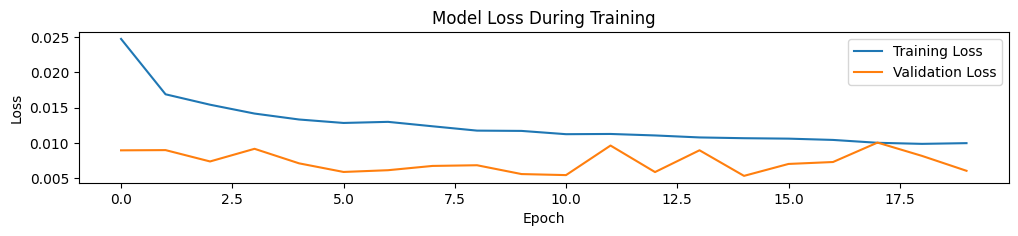

In [15]:
import matplotlib.pyplot as plt


# Create visualizations
plt.figure(figsize=(12, 9))

# Plot 1: Training Loss
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Evaluate Progress

In [16]:
def evaluate_regression_lstm(y_true, y_pred):
    # R² score (1.0 is perfect prediction)
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)
    
    # Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Custom accuracy metric for regression (as percentage)
    # Using 1 - normalized MAE as a proxy for accuracy
    #accuracy = (1 - mae / (y_true.max() - y_true.min())) * 100
    
    print("\nRegression Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    #print(f"Accuracy (based on normalized MAE): {accuracy:.2f}%")
    
    return r2, mae, rmse

### Evaluate 3 Targets

In [17]:
evaluate_regression_lstm(y_test_orig[0], test_pred[0])


Regression Metrics:
R² Score: 0.9991
MAE: 2.7052
RMSE: 3.5640


(0.9991456309555515, 2.705195240974433, 3.5639641441379304)

In [18]:
evaluate_regression_lstm(y_test_orig[0], test_pred[1])


Regression Metrics:
R² Score: 0.9991
MAE: 2.6756
RMSE: 3.6135


(0.9991217036295996, 2.675571732521064, 3.6135254501228)

In [19]:
evaluate_regression_lstm(y_test_orig[2], test_pred[2])


Regression Metrics:
R² Score: 1.0000
MAE: 0.6514
RMSE: 0.8727


(0.999951310855136, 0.6514077854156539, 0.8727085350282227)

## Find Optimal Learning Rate 

In [20]:
# def find_optimal_lr(model, X_train, y_train):
#     lr_schedule = np.logspace(-4, -2, 100)  # Test from 0.0001 to 0.01
#     losses = []
    
#     for lr in lr_schedule:
#         model.optimizer.learning_rate.assign(lr)
#         loss = model.train_on_batch(X_train[:32], y_train[:32])
#         losses.append(loss)
        
#     best_lr = lr_schedule[np.argmin(losses)]
#     return best_lr

# find_optimal_lr(model, X_train, y_train)

## Plot Residuals - Actual vs Predicted

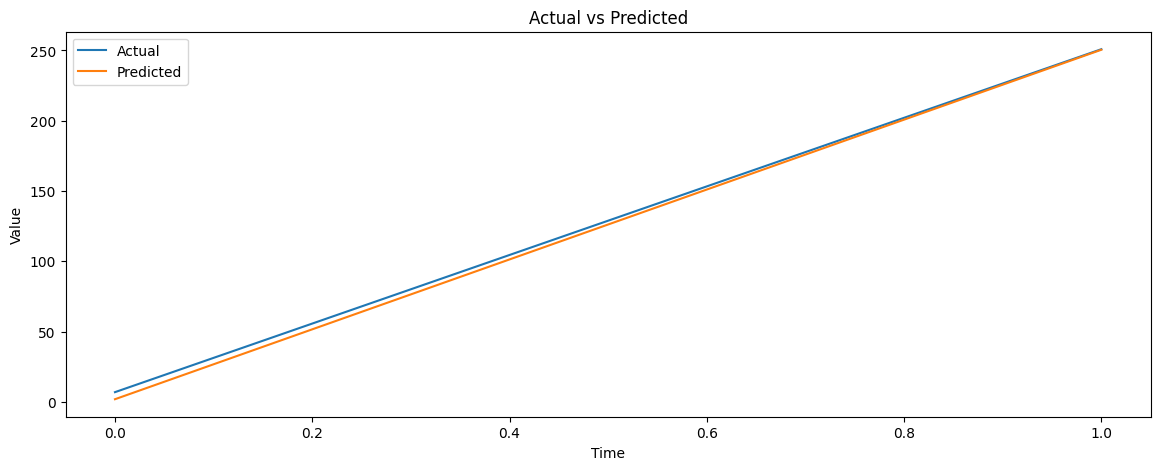

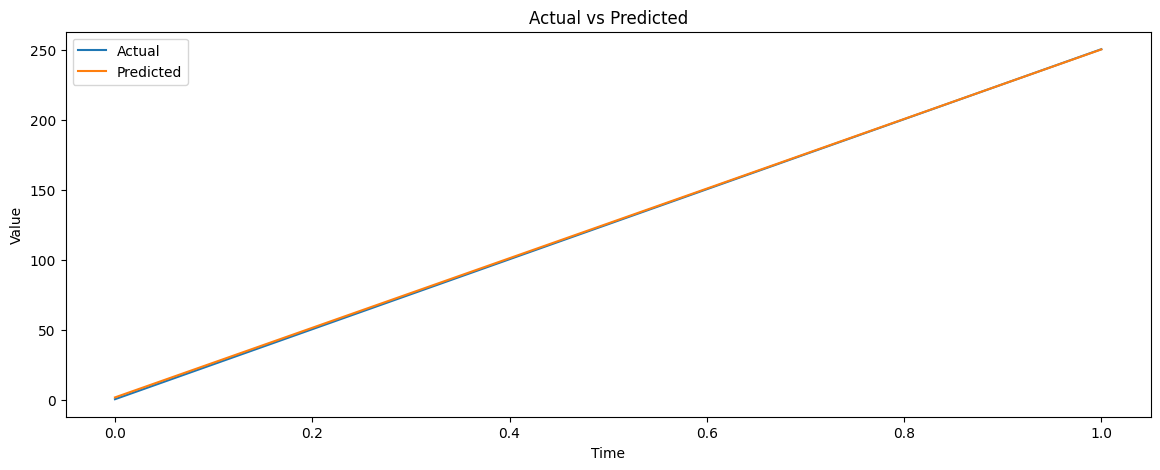

In [23]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted'):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Assuming y_test and test_pred are defined
plot_actual_vs_predicted(y_test_orig[0], test_pred[0])
plot_actual_vs_predicted(y_test_orig[1], test_pred[1])

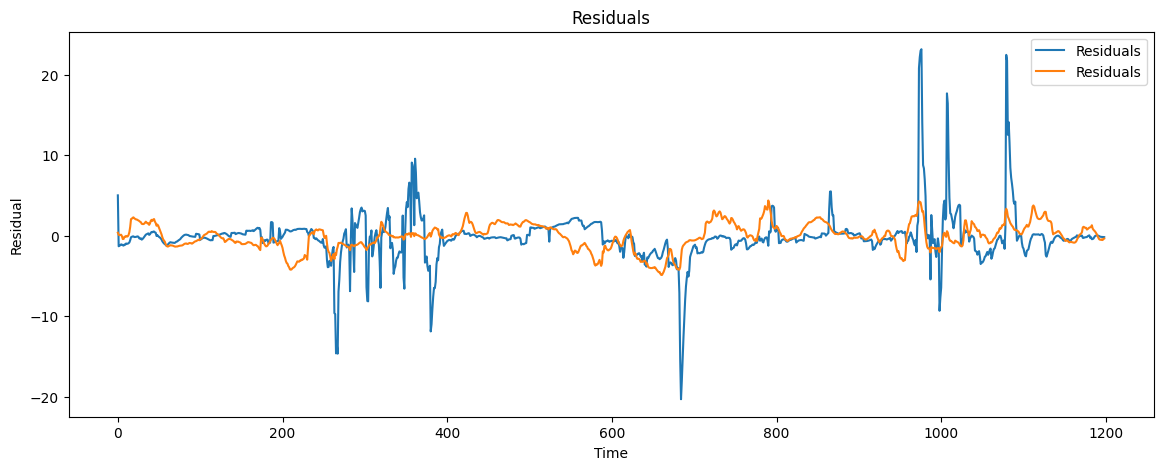

In [22]:
def plot_residuals(y_true, y_pred, title='Residuals'):
    residuals = y_true - y_pred
    plt.figure(figsize=(14, 5))
    plt.plot(residuals, label='Residuals')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()
    
    
plot_residuals(y_test_orig, test_pred, title='Residuals')